# Modern Portfolio Theory i  Post-Modern Portfolio Theory

-------------------------------------
U ovoj bilježnici su izvedeni i prikazani rezultati modela odabira deversifikacije portfolija po uzoru na Modern Portfolio Theory i  Post-Modern Portfolio Theory. Također, uspoređuju se rezultati MPT modela nad dvije vrste portfolija, jednim deversificiranim s dionicama iz više različitih industrija i jednim kojemu su sve dionice iz prijevozničkog sektora.

Učitavanje biblioteka.

In [57]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import finnhub

Definiranje ulaznik podataka.                                                                   

In [58]:
diversifiedPortfolio = {}
transportPortfolio = {}

diversifiedPortfolio['symbols'] = ["RYAAY", "KO", "FB", "MSFT", "UNH", "TSLA", "VOYA", "HON", "LPX", "CNP"]
diversifiedPortfolio['line_name'] = ["Ryanair", "Coca-Cola", "Meta", "Microsoft", "UnitedHealth Group Inc.", "Tesla", "Voya Financial Inc.", "Honeywell International Inc.", "Louisiana-Pacific Corp.", "CenterPoint Energy Inc."]

transportPortfolio['symbols'] = ["AAL", "RYAAY", "EZJ", "DAL", "JBLU", "BLBD", "JBHT", "CAR", "EXPD", "UNP"]
transportPortfolio['line_name'] = ["American Airlines Group", "Ryanair", "easyJet", "Delta Air Lines", "JetBlue", "Blue Bird Corporation", "J.B. Hunt Transport Services", "Avis Budget Group", "Expeditors International", "Union Pacific Corporation"]

num_port = 5000
start_date = '01/01/2015'
end_date = '31/12/2019'
test_start_date = end_date
test_end_date = '20/01/2022'
finnhub_client = finnhub.Client(api_key="c78ocq2ad3icbce88mn0")

Dohvaćanje povijesnih podataka o cijenama s burze i spremanje u dva riječnika, svaki predstavlja jedanu vrstu portfolija (diversificirani i nediversificirani).

In [59]:
modelStart = int(time.mktime(datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
modelEnd = int(time.mktime(datetime.strptime(end_date, "%d/%m/%Y").timetuple()))
testStart = int(time.mktime(datetime.strptime(test_start_date, "%d/%m/%Y").timetuple()))
testEnd = int(time.mktime(datetime.strptime(test_end_date, "%d/%m/%Y").timetuple()))

def getDailyReturns(stockSymbols, start, end):
    data_dict = dict()
    i = 0
    for stock in stockSymbols:

        try:
            response = finnhub_client.stock_candles(stock, 'D', start, end)

            df = pd.DataFrame.from_dict(response)
            df = df.drop(columns=['s', 'h', 'l', 'o', 'v'])

            df['time'] = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in df.t.values]

        except:
            raise ValueError("No data found for " + stock)

        if i != 0 and i % 10 == 0:
            time.sleep(60)
                
        data_dict[stock] = df

        i += 1

    data_to_concat = []
    for key in data_dict:
        data_dict[key] = data_dict[key].rename(columns={"c": key})
        data_to_concat.append(data_dict[key])

    price_data = pd.concat(data_to_concat, axis=1, join='inner')
    price_data = price_data.loc[:,~price_data.columns.duplicated()].drop(columns='t').set_index('time')

    daily_returns = price_data/price_data.shift(1) - 1
    daily_returns = daily_returns.iloc[1: , :]
    return (daily_returns, price_data)
    
(diversifiedPortfolio['daily_returns'], diversifiedPortfolio['price_data']) = getDailyReturns(diversifiedPortfolio['symbols'], modelStart, modelEnd)
time.sleep(60)
(transportPortfolio['daily_returns'], transportPortfolio['price_data']) = getDailyReturns(transportPortfolio['symbols'], modelStart, modelEnd)
time.sleep(60)
(diversifiedPortfolio['test_returns'], diversifiedPortfolio['test_price_data']) = getDailyReturns(diversifiedPortfolio['symbols'], testStart, testEnd)
time.sleep(60)
(transportPortfolio['test_returns'], transportPortfolio['test_price_data']) = getDailyReturns(transportPortfolio['symbols'], testStart, testEnd)

Transformiranje dohvaćenih podataka, računanje pogreške za MPT i PMPT modele i simuliranje portfolia za MPT i PMPT modele nad diversificiranim podacima i MPT modela nad nediversificiranim podacima. Podaci za MPT i PMPT se spremaju u dva nova riječnika, a samo najzanimljivije vrijednosti se spremaju i riječnike koji predstavljaju diversificirani i nediversificirani portfolijo.

sharpRatioModel - podaci za diversficirani MPT model
sortionRatioModel - podaci za diversficirani PMPT model
diversifiedPortfolio - najzanimljiviji podaci za diversficirani MPT model
tranportPortfolio - najzanimljiviji podaci za nediversficirani MPT model

In [60]:
# MODELS BASED ON DIFFERENT RISKS
sharpRatioModel = {}
sortionRatioModel = {}

daily_returns = diversifiedPortfolio['daily_returns']

downside_daily_returns = daily_returns.copy()
for i in range(0, len(downside_daily_returns.iloc[:,0])):
    for j in range(0, len(downside_daily_returns.iloc[0,:])):
        if downside_daily_returns.iloc[i,j] >= 0:
            downside_daily_returns.iloc[i,j] = np.NaN

cov_mat = daily_returns.cov()
downside_cov_mat = downside_daily_returns.cov()

weights_matrix = np.zeros((num_port, len(daily_returns.columns)))
returns = np.zeros((num_port))

sharpRatioModel['ratios'] = np.zeros((num_port))
sortionRatioModel['ratios'] = np.zeros((num_port))

sharpRatioModel['risks'] = np.ones((num_port))
sortionRatioModel['risks'] = np.ones((num_port))

# transport portfolio helper variables
trans_cov_mat = transportPortfolio['daily_returns'].cov()
trans_sharpRatios = np.zeros((num_port))

# SIMULATE x PORTFOLIOS

np.random.seed(42)

for i in range(num_port):

    # Portfolio weights
    wts = np.random.uniform(size=len(daily_returns.columns))
    wts = wts / np.sum(wts)
    weights_matrix[i, :] = wts

    # Portfolio Return
    port_ret = np.sum(daily_returns.mean() * wts) * 252
    returns[i] = port_ret

    # Portfolio Standard Deviation Risk
    port_standard_deviation = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts))) * np.sqrt(252)
    sharpRatioModel['risks'][i] = port_standard_deviation

    # Portfolio Sharpe Ratio, assuming 0% Risk Free Rate
    port_sharp_ratio = port_ret / port_standard_deviation
    sharpRatioModel['ratios'][i] = port_sharp_ratio

    # Portfolio Downside Risk
    port_semi_deviation = np.sqrt(np.dot(wts.T, np.dot(downside_cov_mat, wts))) * np.sqrt(252)
    sortionRatioModel['risks'][i] = port_semi_deviation

    # Portfolio Sortino Ratio, assuming 0% Risk Free Rate
    port_sortion_ratio = port_ret / port_semi_deviation
    sortionRatioModel['ratios'][i] = port_sortion_ratio

    # Save portfolios of interest (min var, max return and max SR)
    if port_ret >= max(returns[0:-1]):
        sharpRatioModel['max_ret_ret'] = port_ret
        sharpRatioModel['max_ret_risk'] = port_standard_deviation
        sharpRatioModel['max_ret_w'] = wts

        sortionRatioModel['max_ret_ret'] = port_ret
        sortionRatioModel['max_ret_risk'] = port_semi_deviation
        sortionRatioModel['max_ret_w'] = wts
        
    if port_standard_deviation <= min(sharpRatioModel['risks'][0:-1]):
        sharpRatioModel['min_risk_ret'] = port_ret
        sharpRatioModel['min_risk_risk'] = port_standard_deviation
        sharpRatioModel['min_risk_w'] = wts

    if port_sharp_ratio >= max(sharpRatioModel['ratios'][0:-1]):
        sharpRatioModel['max_ratio_ret'] = port_ret
        sharpRatioModel['max_ratio_risk'] = port_standard_deviation
        sharpRatioModel['max_ratio_w'] = wts
        sharpRatioModel['max_ratio'] = port_sharp_ratio
    
    if port_semi_deviation <= min(sortionRatioModel['risks'][0:-1]):
        sortionRatioModel['min_risk_ret'] = port_ret
        sortionRatioModel['min_risk_risk'] = port_semi_deviation
        sortionRatioModel['min_risk_w'] = wts

    if port_sortion_ratio >= max(sortionRatioModel['ratios'][0:-1]):
        sortionRatioModel['max_ratio_ret'] = port_ret
        sortionRatioModel['max_ratio_risk'] = port_semi_deviation
        sortionRatioModel['max_ratio_w'] = wts
        sortionRatioModel['max_ratio'] = port_sortion_ratio

    ### Transport Portfolio

    # Portfolio Return
    port_ret = np.sum(transportPortfolio['daily_returns'].mean() * wts) * 252

    # Portfolio Standard Deviation Risk
    port_standard_deviation = np.sqrt(np.dot(wts.T, np.dot(trans_cov_mat, wts))) * np.sqrt(252)

    # Portfolio Sharpe Ratio, assuming 0% Risk Free Rate
    port_sharp_ratio = port_ret / port_standard_deviation
    trans_sharpRatios[i] = port_sharp_ratio

    if port_sharp_ratio >= max(trans_sharpRatios[0:-1]):
        transportPortfolio['max_sharpRatio_ret'] = port_ret
        transportPortfolio['max_sharpRatio_risk'] = port_standard_deviation
        transportPortfolio['max_sharpRatio_w'] = wts
        transportPortfolio['max_sharpRatio'] = port_sharp_ratio

diversifiedPortfolio['max_sharpRatio_ret'] = sharpRatioModel['max_ratio_ret']
diversifiedPortfolio['max_sharpRatio_risk'] = sharpRatioModel['max_ratio_risk']
diversifiedPortfolio['max_sharpRatio_w'] = sharpRatioModel['max_ratio_w']
diversifiedPortfolio['max_sharpRatio'] = sharpRatioModel['max_ratio']

### The Efficient Frontier

Prikaz omjera povrata i rizika simuliranih portfolija za MPT model (Sharp ratio graf) i PMPT (Sortion ratio graf). Linija koja bi predstavljala Efficient Frontier bi prolazila kroz sve portfolije koji za neku razinu rizika imaju maksimalni povrat. Crvenom bojom je označen portfolio s najmanjim rizikom, žutom portfolio s najvećim povratom, a ljubičastom portfolio s najvećim omjerom povrata i rizika (najbolji portfolio). Možemo primjetiti da u ova 2 modela grafički daju vrlo slično grupirane kombinacije, no graf za PMPT je pomaknut u lijevo po x-osi. Razlog tomu je drugačije računanje rizika, PMPT uzima u obzir samo pad cijena.

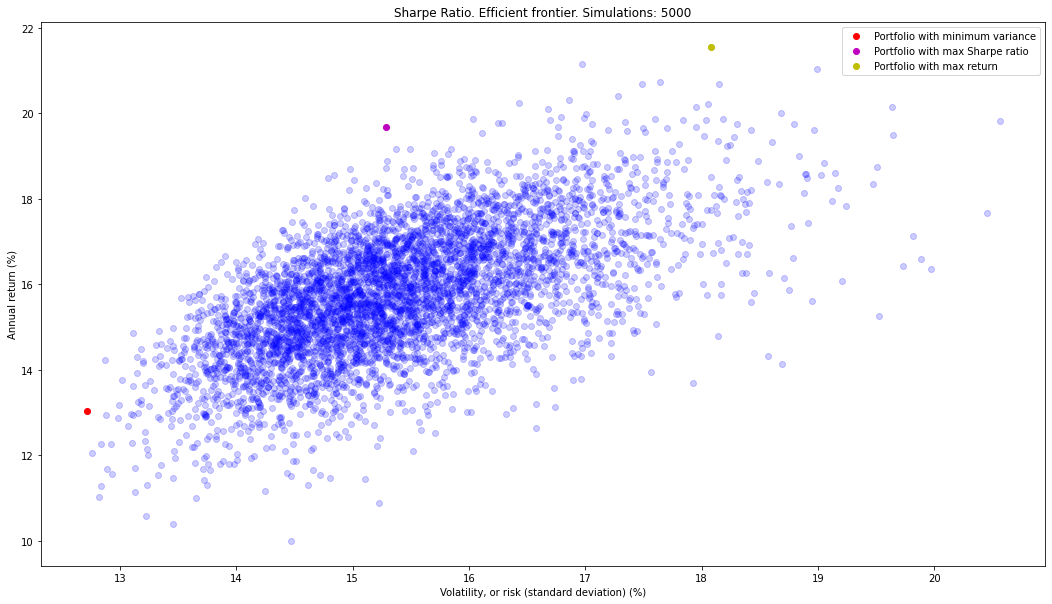

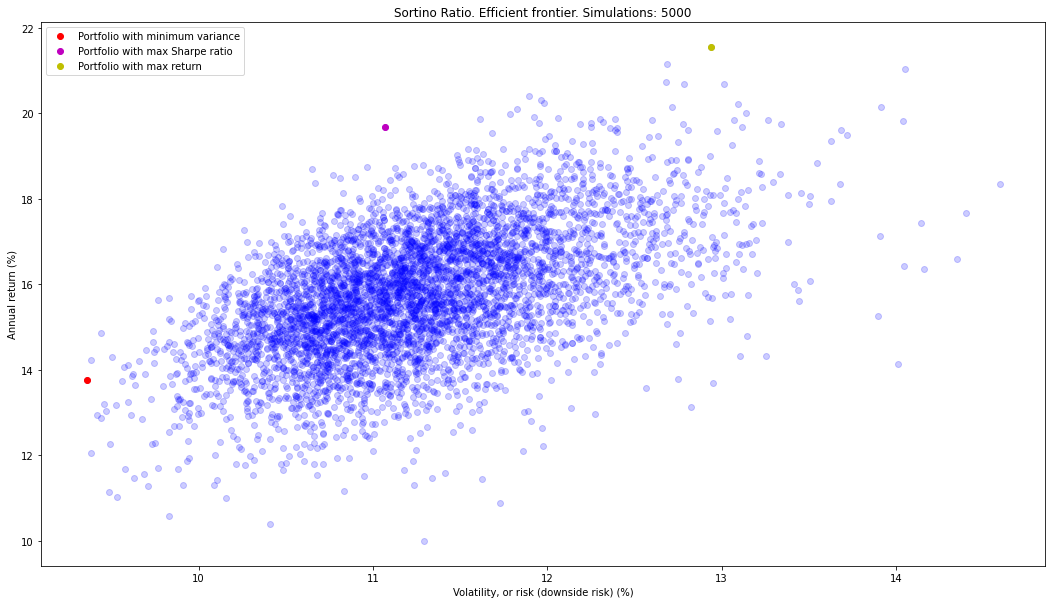

In [61]:
def efficient_frontier(all_port_risks, all_port_returns, min_risk_risk, min_risk_ret, max_sr_risk, max_sr_ret, max_ret_risk, max_ret_ret, title, risk_type):
    plt.figure(figsize=(18, 10), facecolor='w')
    plt.title(title + " Efficient frontier. Simulations: " + str(num_port))
    plt.plot(all_port_risks*100, all_port_returns*100, 'bo', alpha=0.2)
    plt.plot(min_risk_risk*100, min_risk_ret*100, 'ro', label='Portfolio with minimum variance')
    plt.plot(max_sr_risk*100, max_sr_ret*100, 'mo', label='Portfolio with max Sharpe ratio')
    plt.plot(max_ret_risk*100, max_ret_ret*100, 'yo', label='Portfolio with max return')
    plt.xlabel('Volatility, or risk (' + risk_type + ') (%)')
    plt.ylabel('Annual return (%)')
    plt.legend(loc="best")
    plt.show()

efficient_frontier(sharpRatioModel['risks'], returns, 
    sharpRatioModel['min_risk_risk'], sharpRatioModel['min_risk_ret'], 
    sharpRatioModel['max_ratio_risk'], sharpRatioModel['max_ratio_ret'], 
    sharpRatioModel['max_ret_risk'], sharpRatioModel['max_ret_ret'], 
    'Sharpe Ratio.', 'standard deviation')
efficient_frontier(sortionRatioModel['risks'], returns, 
    sortionRatioModel['min_risk_risk'], sortionRatioModel['min_risk_ret'], 
    sortionRatioModel['max_ratio_risk'], sortionRatioModel['max_ratio_ret'], 
    sortionRatioModel['max_ret_risk'], sortionRatioModel['max_ret_ret'], 
    'Sortino Ratio.', 'downside risk')


### Težinski raspored unutar portfolija

Prikaz težinskog rasporeda unutar portfolija za neke zanimljive portfolije. Prikazani su portfoliji MPT modela koji imaju minimalan rizik, najbolji omjer povrata i rizika (Sharpe ratio), maksimalan povrat i graf PMPT modela s najboljim omjerom povrata i rizika (Sortion ratio). Kod 2 grafa s najboljim omjerima možemo primjetiti da je to zapravo isti portfolio (s isitim težinama). Dakle, možemo zaključiti da promjena funkcije za rizik kod PMPT modela ne rezultira sa značajnim pomjenama kod odabira težina. Dakle, MPT i PMPT modeli imaju više razlike u semantičkom tumačenju jer PMPT uzima u kalkulacije za rizik samo padove cijena.

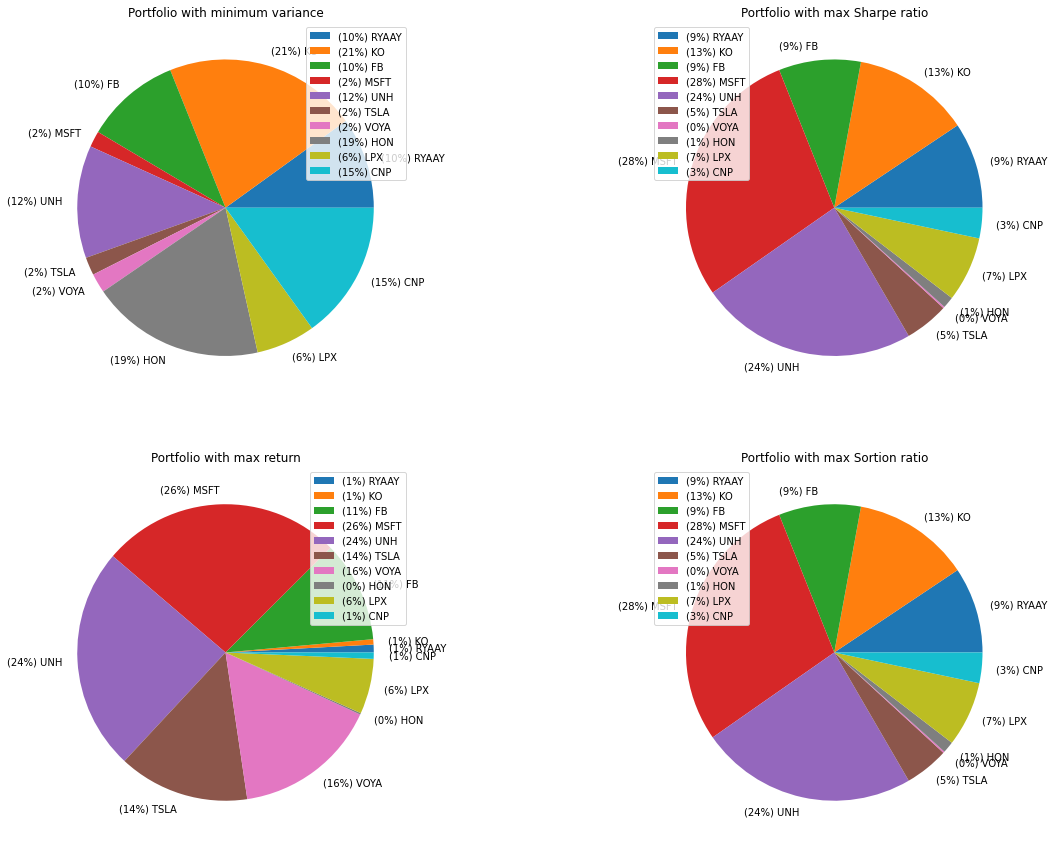

In [62]:
def plot_portfolio_composition(symbols, weights, plot_name, order):
    labels = []
    for i in range(0, len(symbols)):
        labels.append('(' + str(int(round(weights[i], 2)*100)) + '%) ' + symbols[i])
    ax = fig.add_subplot(2, 2, order)
    ax.title.set_text(plot_name)
    ax.grid()
    plt.pie(weights, labels=labels)
    plt.legend()

fig = plt.figure(figsize=(20,15), facecolor='w')
plot_portfolio_composition(diversifiedPortfolio['symbols'], sharpRatioModel['min_risk_w'], "Portfolio with minimum variance", 1)
plot_portfolio_composition(diversifiedPortfolio['symbols'], sharpRatioModel['max_ratio_w'], "Portfolio with max Sharpe ratio", 2)
plot_portfolio_composition(diversifiedPortfolio['symbols'], sharpRatioModel['max_ret_w'], "Portfolio with max return", 3)
plot_portfolio_composition(diversifiedPortfolio['symbols'], sortionRatioModel['max_ratio_w'], "Portfolio with max Sortion ratio", 4)
plt.show()

### Cijene dionica i divrsiciranog portfolija tijekom vremena (vremenski period nad kojim su se modeli učili)

Ovdje vidimo kretanje cijena za dionice i diversicirinai portfolio tijekom skoro tri godine. Promatrajući crvenu liniju koja označava naš portfolijo možemo primjetiti da su samo 3 dionice ostvarile veću dobit od našeg portfolija. Mislim kako je to vrlo dobar uspijeh s obzirom da smo diversifikacijom značajno smanjili rizik.

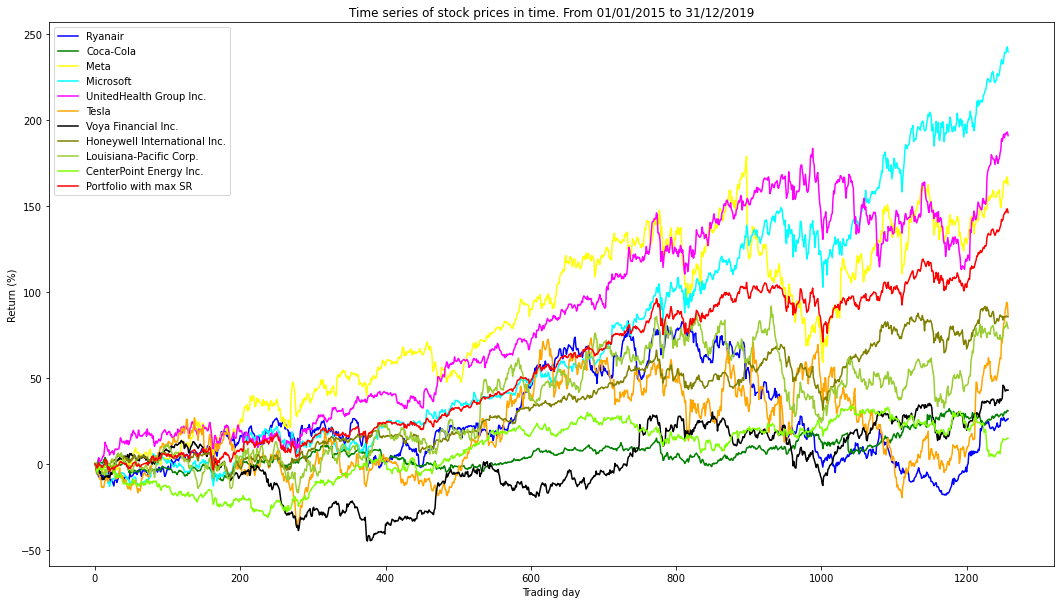

In [63]:
color_list = ["blue", "green", "yellow", "cyan", "magenta", "orange", "black", "olive", "yellowgreen", "chartreuse"]

plt.figure(figsize=(18, 10), facecolor='w')
plt.title('Time series of stock prices in time. From ' + start_date + ' to ' + end_date)

i = 0
val_max_shr = 0

price_data = diversifiedPortfolio['price_data']

for symbol in diversifiedPortfolio['daily_returns']:
    plt.plot(range(0, len(price_data[symbol])), list(price_data[symbol]/(price_data[symbol][0])*100-100),
                color=color_list[i], label=diversifiedPortfolio['line_name'][i])

    val_max_shr += price_data[symbol] / (price_data[symbol][0]) * sharpRatioModel['max_ratio_w'][i]

    i += 1

plt.plot(range(0, len(diversifiedPortfolio['daily_returns']) + 1), list(val_max_shr*100-100), label="Portfolio with max SR",
            color='red')
plt.xlabel('Trading day')
plt.ylabel('Return (%)')
plt.legend(loc="best")
plt.show()

### Deversificirani u odnosu na nediversificirani portfolio

Ovdje vidimo odnos rizika i povrata za diversificirani i transportni portfolio. Diversificirani portfolio ima jedan posto veći rizik, no zato ima 8 posto veći povrat što je zaista sjajno. Ovo nam pokazuje kako diversifikacijom mozemo postići velike povrate sa gotov jednakim rizikom.

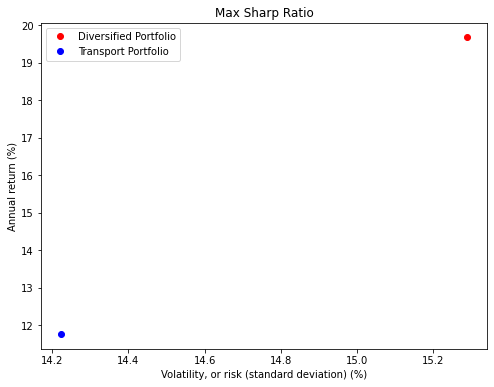

In [64]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title("Max Sharp Ratio")
plt.plot(diversifiedPortfolio['max_sharpRatio_risk']*100, diversifiedPortfolio['max_sharpRatio_ret']*100, 'ro', label='Diversified Portfolio')
plt.plot(transportPortfolio['max_sharpRatio_risk']*100, transportPortfolio['max_sharpRatio_ret']*100, 'bo', label='Transport Portfolio')
plt.xlabel('Volatility, or risk (standard deviation) (%)')
plt.ylabel('Annual return (%)')
plt.legend(loc="best")
plt.show()

Težinski prikaz oba portfolija.

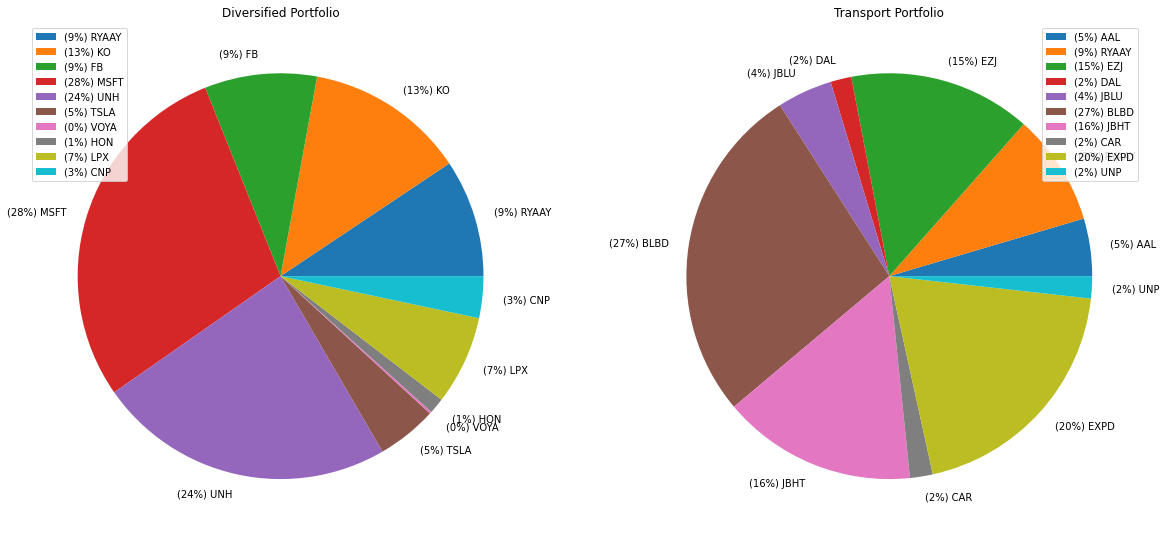

In [65]:
def plot_portfolio_composition(symbols, weights, plot_name, order):
    labels = []
    for i in range(0, len(symbols)):
        labels.append('(' + str(int(round(weights[i], 2)*100)) + '%) ' + symbols[i])
    ax = fig.add_subplot(1, 2, order)
    ax.title.set_text(plot_name)
    ax.grid()
    plt.pie(weights, labels=labels)
    plt.legend()

fig = plt.figure(figsize=(20,15), facecolor='w')
plot_portfolio_composition(diversifiedPortfolio['symbols'], diversifiedPortfolio['max_sharpRatio_w'], 'Diversified Portfolio', 1)
plot_portfolio_composition(transportPortfolio['symbols'], transportPortfolio['max_sharpRatio_w'], 'Transport Portfolio', 2)
plt.show()

### Usporedba povrata za diversificirani i transportni portfolijo na testnom razdoblju od dvije godine

Testirali smo dva portfolija na neviđenim primjerima za testiranje. Pošto su izračunati rizici za oba portfolija bili relativno mali, oba portfolija su ostvarili i čak nadmašili očekivani povrat. Diversificirani povrat je postigao gotovo dupli povrat u odnosu na transportni.

In [66]:
diversified_test_ret = np.sum(diversifiedPortfolio["test_returns"].mean() * diversifiedPortfolio["max_sharpRatio_w"]) * 252
tech_test_ret = np.sum(transportPortfolio["test_returns"].mean() * transportPortfolio["max_sharpRatio_w"]) * 252

print("Annual returns test on period [" + test_start_date + " - " + test_end_date + "]")
print("Diversified Portfolio: " + str(diversified_test_ret*100) + "%")
print("Transport Portfolio: " + str(tech_test_ret*100) + "%")

Annual returns test on period [31/12/2019 - 20/01/2022]
Diversified Portfolio: 35.330236293929026%
Transport Portfolio: 18.314459956342994%
